**Imports and workspace setting**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
plt.style.use('ggplot')

**Loading data file**

In [2]:
cancerData = pd.read_csv('../data/breast-cancer-wisconsin.data', header=None)
cancerData.drop(cancerData.columns[0],axis=1,inplace=True)
cancerData = cancerData.replace('?', np.nan)
cancerData.head()

,1,2,3,4,5,6,7,8,9,10
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


**Stats of the data**

In [3]:
cancerData.shape

(699, 10)

**Class distribution of benign (2) and malignant (4)**

Class distribution is skewed towards benign.

Text(0.5, 0, 'Class')

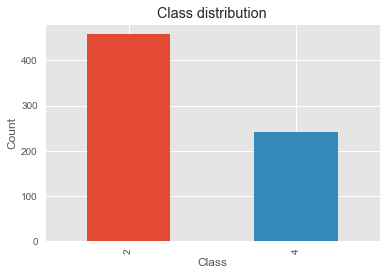

In [4]:
fig, ax = plt.subplots(figsize=(6,4))
axes = cancerData[10].value_counts().plot(kind='bar', title='Class distribution')
axes.set_ylabel('Count')
axes.set_xlabel('Class')

**Drop missing values (16 values with ? mark)**

In [5]:
cancerDataAfterMissingValuesDropped = cancerData.dropna()
cancerDataAfterMissingValuesDropped.shape

(683, 10)

In [6]:
y = cancerDataAfterMissingValuesDropped.values[:,-1]
y=y.astype('int')
y.shape

(683,)

In [7]:
X = cancerDataAfterMissingValuesDropped.values[:,:-1]
X=X.astype('int')
X.shape

(683, 9)

**Holdout to create training (65%) and testing (35%) dataset**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=8)
print (str(X_train.shape) +","+ str(y_train.shape))
print (str(X_test.shape) +","+ str(y_test.shape))

(443, 9),(443,)
(240, 9),(240,)


**Hyper paramter tuning for Random Forest**

In [9]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  5.5min finished


{'bootstrap': True,
 'max_depth': 90,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 100}

**Fit Random forest model**

In [10]:
randomForest = RandomForestClassifier(**grid_search.best_params_, random_state=0)
randomForest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=12,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [11]:
predictions = randomForest.predict(X_test)

In [12]:
score = randomForest.score(X_test, y_test)
print('Accuracy score = ', score)

Accuracy score =  0.9791666666666666


**Classification report**

In [13]:
target_names = ['2 (benign)', '4 (malignant)']
print(metrics.classification_report(y_test,predictions, target_names=target_names, digits=3))

               precision    recall  f1-score   support

   2 (benign)      0.980     0.986     0.983       147
4 (malignant)      0.978     0.968     0.973        93

    micro avg      0.979     0.979     0.979       240
    macro avg      0.979     0.977     0.978       240
 weighted avg      0.979     0.979     0.979       240



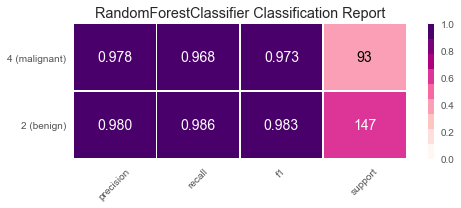

In [14]:
fig, ax = plt.subplots(figsize=(7,3))
visualizer = ClassificationReport(randomForest, classes=target_names, support=True, cmap='RdPu')
visualizer.score(X_test, y_test)
for label in visualizer.ax.texts:
    label.set_size(14)
g = visualizer.poof()

**Confusion metrix**

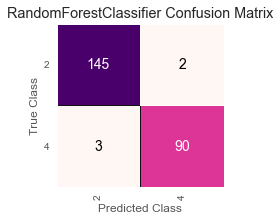

In [15]:
fig, ax = plt.subplots(figsize=(3,3))
cm = ConfusionMatrix(randomForest, classes=[2,4], cmap='RdPu')
cm.score(X_test, y_test)
for label in cm.ax.texts:
    label.set_size(14)
cm.poof()

**Conclusion**
01. Model works really well and provides an impression 97.91% accuracy after hyper parameter tuning was included. Before hyper parameter tuning, only 97.5% was achived which is also better than all classifiers tested so far.
02. Skewed class problem is seen clearly with random foress classifier as well. All measures of malignant class were less than the benign class. Random forest does not have a method to weight the class distribution like in LogisticRegression.